# DEEP LEARNING 

memisahkan data menjadi 3 bagian :

1. train data
2. test data
3. validation data

# memasukkan dataset

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import shutil
from tqdm.notebook import tqdm as tq
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model
# from efficientnet.tfkeras import EfficientNetB1

# memasukkan folder yang nantinya di jadikan ke dataset

In [84]:
mypath = 'Toyota_car/'

In [85]:
file_name = []
tags = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name).replace("\\","/"))
        tags.append(path.split('/')[-1])
        file_name.append(name)

In [86]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(mypath):
    counting = len(os.listdir(os.path.join(mypath, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 540


In [87]:
df = pd.DataFrame({'path': full_path, 'file_name': file_name, "tag":tags})
df.groupby(['tag']).size()

tag
Alphard          107
Avanza           107
Kijang_Innova    107
Rush             119
Yaris            100
dtype: int64

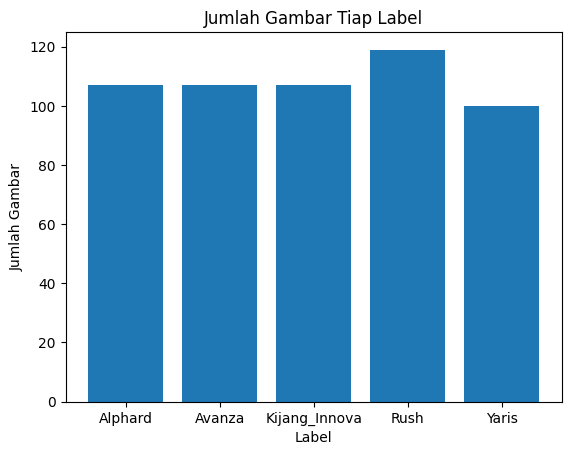

In [88]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

print();

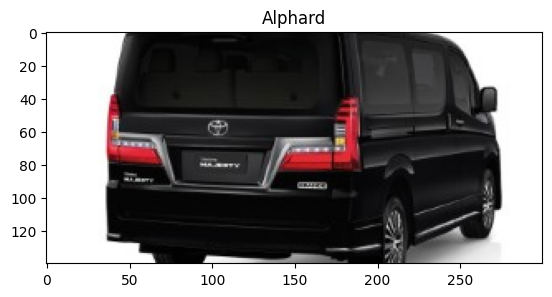

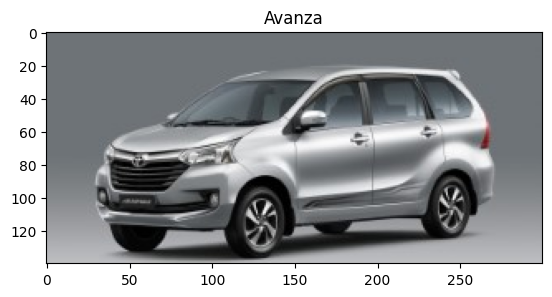

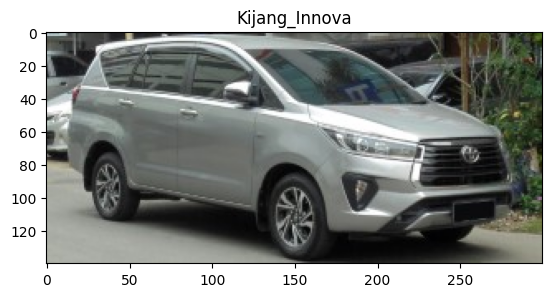

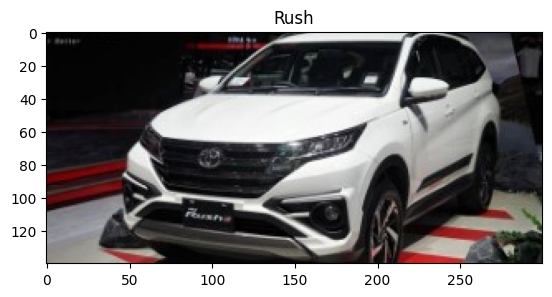

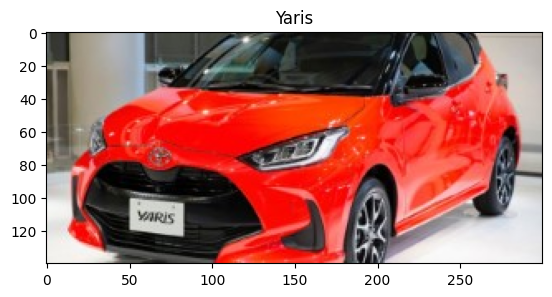

In [89]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())

for c in classes:
    temp = os.listdir(os.path.join(mypath, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(mypath, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

In [91]:
## Data Preparation

"""
Setelah memahami data, selanjutnya adalah mempersiapkan data sebelum nantinya masuk ke modelling. Penyiapan ini termasuk didalamnya adalah pembagian data (split) menjadi data latih dan validasi. Pembagian data ini diperlukan sebelum nantinya digunakan untuk melatih model yang dibuat serta menghitung akurasi modelnya.
"""

IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32
SEED = 999

# train data

In [92]:
X = df['path']
y = df['tag']

In [93]:
# memisahkan split data antara train, test dan validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# kemudian:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [94]:
df_tr = pd.DataFrame({'path': X_train, 'tag': y_train, 'set':'train'})

df_te = pd.DataFrame({'path':X_test, 'tag':y_test, 'set':'test'})

df_val = pd.DataFrame({'path': X_val, 'tag': y_val, 'set': 'validation'})

In [95]:
print('train_size', len(df_tr))
print('test_size', len(df_te))
print('val size', len(df_val))

train_size 264
test_size 162
val size 114


In [96]:
df_all = df_tr.append([df_te, df_val]).reset_index(drop=1)

print('=====================================================\n')
print(df_all.groupby(['set', 'tag']).size(), '\n')

print('========================================================\n')

df_all.sample(3)


set         tag          
test        Alphard          32
            Avanza           25
            Kijang_Innova    33
            Rush             42
            Yaris            30
train       Alphard          51
            Avanza           61
            Kijang_Innova    54
            Rush             53
            Yaris            45
validation  Alphard          24
            Avanza           21
            Kijang_Innova    20
            Rush             24
            Yaris            25
dtype: int64 




C:\Users\ACER\AppData\Local\Temp\ipykernel_2072\2411525728.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_tr.append([df_te, df_val]).reset_index(drop=1)


,path,tag,set
486,Toyota_car/Kijang_Innova/image_164.jpg,Kijang_Innova,validation
316,Toyota_car/Kijang_Innova/image_117.jpg,Kijang_Innova,test
458,Toyota_car/Alphard/image_24.jpg,Alphard,validation


# merapikan ke folder masing masing 

In [97]:
datasource_path = "Toyota_car/"
dataset_path = "dataset/"

In [98]:
for index, row in tq(df_all.iterrows(), ):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [99]:
# Define Input Parameters
dim = (160, 160)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 16

#Epoch
epoch = 10

In [61]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [64]:
train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 540 images belonging to 5 classes.
Found 540 images belonging to 5 classes.
Found 540 images belonging to 5 classes.


In [66]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [67]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

In [68]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 128)     3584      
                                                                 
 activation (Activation)     (None, 160, 160, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 158, 158, 32)      36896     
                                                                 
 activation_1 (Activation)   (None, 158, 158, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 79, 79, 32)        0         
                                                        

In [70]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [71]:
EPOCH = 10

In [72]:
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=len(val_generator), 
        shuffle=True,
        verbose = 1)

Epoch 1/10
34/34 [==============================] - 78s 2s/step - loss: 1.7266 - accuracy: 0.2481 - val_loss: 1.6045 - val_accuracy: 0.1870
Epoch 2/10
34/34 [==============================] - 78s 2s/step - loss: 1.5831 - accuracy: 0.2556 - val_loss: 1.5793 - val_accuracy: 0.2593
Epoch 3/10
34/34 [==============================] - 77s 2s/step - loss: 1.5544 - accuracy: 0.2704 - val_loss: 1.5187 - val_accuracy: 0.3019
Epoch 4/10
34/34 [==============================] - 76s 2s/step - loss: 1.5242 - accuracy: 0.2833 - val_loss: 1.4966 - val_accuracy: 0.2833
Epoch 5/10
34/34 [==============================] - 72s 2s/step - loss: 1.5270 - accuracy: 0.2611 - val_loss: 1.4717 - val_accuracy: 0.2981
Epoch 6/10
34/34 [==============================] - 73s 2s/step - loss: 1.4986 - accuracy: 0.2889 - val_loss: 1.4735 - val_accuracy: 0.3296
Epoch 7/10
34/34 [==============================] - 76s 2s/step - loss: 1.4712 - accuracy: 0.3000 - val_loss: 1.4421 - val_accuracy: 0.3148
Epoch 8/10
34/34 [==

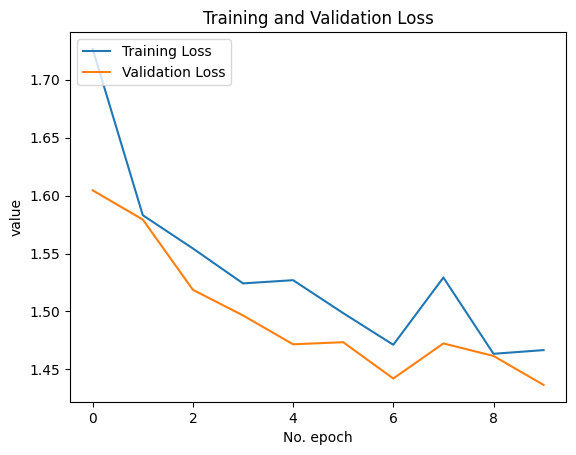

In [73]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

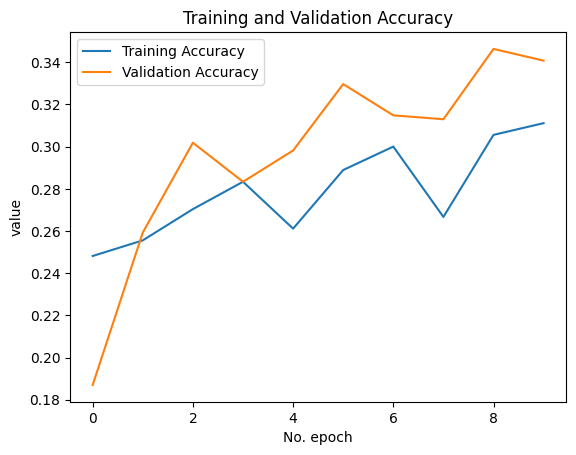

In [74]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [75]:
loss, acc = model.evaluate(train_data, steps=len(train_generator), verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data, steps=len(test_generator), verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')    

Accuracy on training data: 0.3315 
Loss on training data: 1.4537 

Accuracy on test data: 0.3185 
Loss on test data: 1.4576 

